In [189]:
import numpy as np #Working with arrays
import pandas as pd #working with the dataset from yfinance API
import yfinance as yf
import matplotlib.pyplot as plt #need some visualisation

#Build and train the model with pytorch
import torch
import torch.nn as nn
import torch.optim as optim

#Scale and evaluate our metric
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [190]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [191]:
ticker = 'MSFT'
df = yf.download(ticker, '2020-01-01')

C:\Users\kaing\AppData\Local\Temp\ipykernel_16924\3186683050.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [192]:
df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,153.042313,153.147124,150.860356,151.289123,22622100
2020-01-03,151.136673,152.403928,150.603095,150.850838,21116200
2020-01-06,151.527344,151.594048,149.126227,149.669343,20813700
2020-01-07,150.145737,152.137132,149.898008,151.803653,21634100
2020-01-08,152.537277,153.213787,150.498239,151.432000,27746500
...,...,...,...,...,...
2025-07-14,503.019989,503.970001,501.029999,501.519989,12058800
2025-07-15,505.820007,508.299988,502.790009,503.019989,14927200


<Axes: xlabel='Date'>

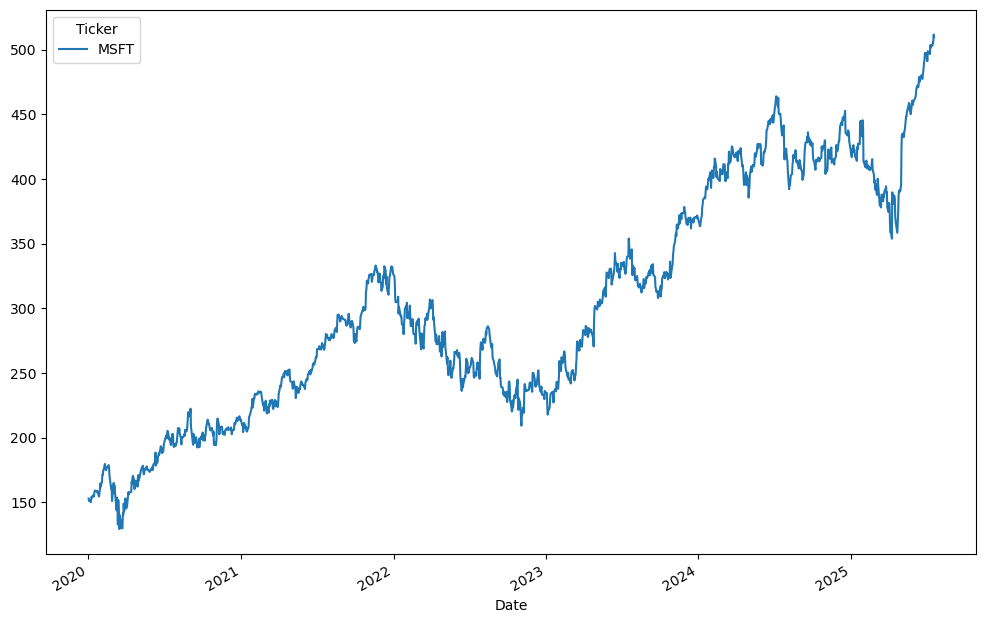

In [193]:
df.Close.plot(figsize=(12,8))

In [194]:
'''
fit_transform computes the min and max of the 'Close' column
Then, each value is scaled using x' = (x -min) / (max -min)
The result is that all values in 'Close' will be between 0 and 1 (unless you pass a custom range with feature_range=(a, b)).


Previously we used standard scaler:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
Resulting values are centered around 0
Distribution has mean = 0 and std = 1

Example:
[100, 110, 120, 130, 140]

STANDARD SCALER: [-1.41, -0.71, 0.0, 0.71, 1.41]  # mean 0, std 1
MINMAXSCALER: [0.0, 0.25, 0.5, 0.75, 1.0]  # scaled between 0 and 1

'''
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])

In [195]:
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.669516
2020-01-03,-1.690933
2020-01-06,-1.686542
2020-01-07,-1.702069
2020-01-08,-1.675192
...,...
2025-07-14,2.263662
2025-07-15,2.295129
2025-07-16,2.292882


In [196]:
#You use 80% of the data for training, the rest for testing.
#Better to split the data between training and test as we want our model to perform well under unseen data.
#If we do not split, the model might be too 'used' to the training data set ad will struggle in real world scenarios"
#In this case, we will do a 80:20 split but a 70:30 is also acceptable

seq_length = 30 #using 30 days
data = []

'''
This creates sliding windows of n consecutive days from the 'Close' prices.
For example:
i=0 → days 0 to 29 (predict day 29)
i=1 → days 1 to 30 (predict day 30)
So each item in data is a window of 30 days, where the first 29 are inputs and the 30th is the prediction target.
'''
for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 * len(data)) #80% as the training data

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 1090
Test samples: 273


In [197]:
class PredictionModel(nn.Module):

    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        #Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])

        return out
    

In [198]:
 model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device) #mOdule needs to be sent to GPU

In [199]:
criterion = nn.MSELoss() #MEAN SQUARED ERROR
optimiser = optim.Adam(model.parameters(), lr=0.01) #learning rate = 0.01 for now

In [200]:
'''
This section is the training loop for your LSTM-based time-series prediction model.
it runs for num_epochs epochs and gradually reduces prediction error using gradient descent.

On each epoch, the model:
    Makes predictions
    Calculates how wrong they are (loss)
    Updates weights to do better next time
'''
num_epochs = 600

for i in range(num_epochs):

    #Make the prediction
    y_train_pred = model(X_train)

    #We see how wrong is this prediction
    loss = criterion(y_train_pred, y_train) # prediction vs actual values

    if i % 25 == 0:
        print(i,loss.item())

    #We back propogate the loss and tweak it to move in the correct direction
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    

0 0.6791417002677917
25 0.37057656049728394
50 0.05528205260634422
75 0.014513098634779453
100 0.00939089059829712
125 0.008921336382627487
150 0.008601515553891659
175 0.008302007801830769
200 0.008012805134057999
225 0.007735549937933683
250 0.007474379613995552
275 0.007232098840177059
300 0.007008069194853306
325 0.0067986976355314255
350 0.00660020811483264
375 0.006410372909158468
400 0.006228249985724688
425 0.0060534304939210415
450 0.00588564807549119
475 0.005724635440856218
500 0.0055701215751469135
525 0.005421909503638744
550 0.0052799624390900135
575 0.005144430790096521


In [201]:
'''
THAT WAS THE TRAINED MODEL, NOW LETS SEE THE HOW THE MODEL PERFORMS ON UNSEEN DATA
'''

'''
Previously, we scaled all price datausing the MinMaxScaler before training to bring it within a range of [0,1]
Now we are reversing that so we can interpret the predictions in actual price values (e.g., dollars).

For example:
original_prices = [100, 120, 130, 110, 115, 140]
scaled_prices that go into the neural network: [0.00, 0.25, 0.375, 0.50, 0.75, 1.00]

Lets say after training, the model predicts this on the test set:
y_test_pred_scaled = [[0.25], [0.5], [0.75]] <----- these outputs are still scaled

So we need convert them back into dollars($) and plot them
'''

model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())




Final Results:
Training RMSE: 6.3048
Test RMSE: 15.5938


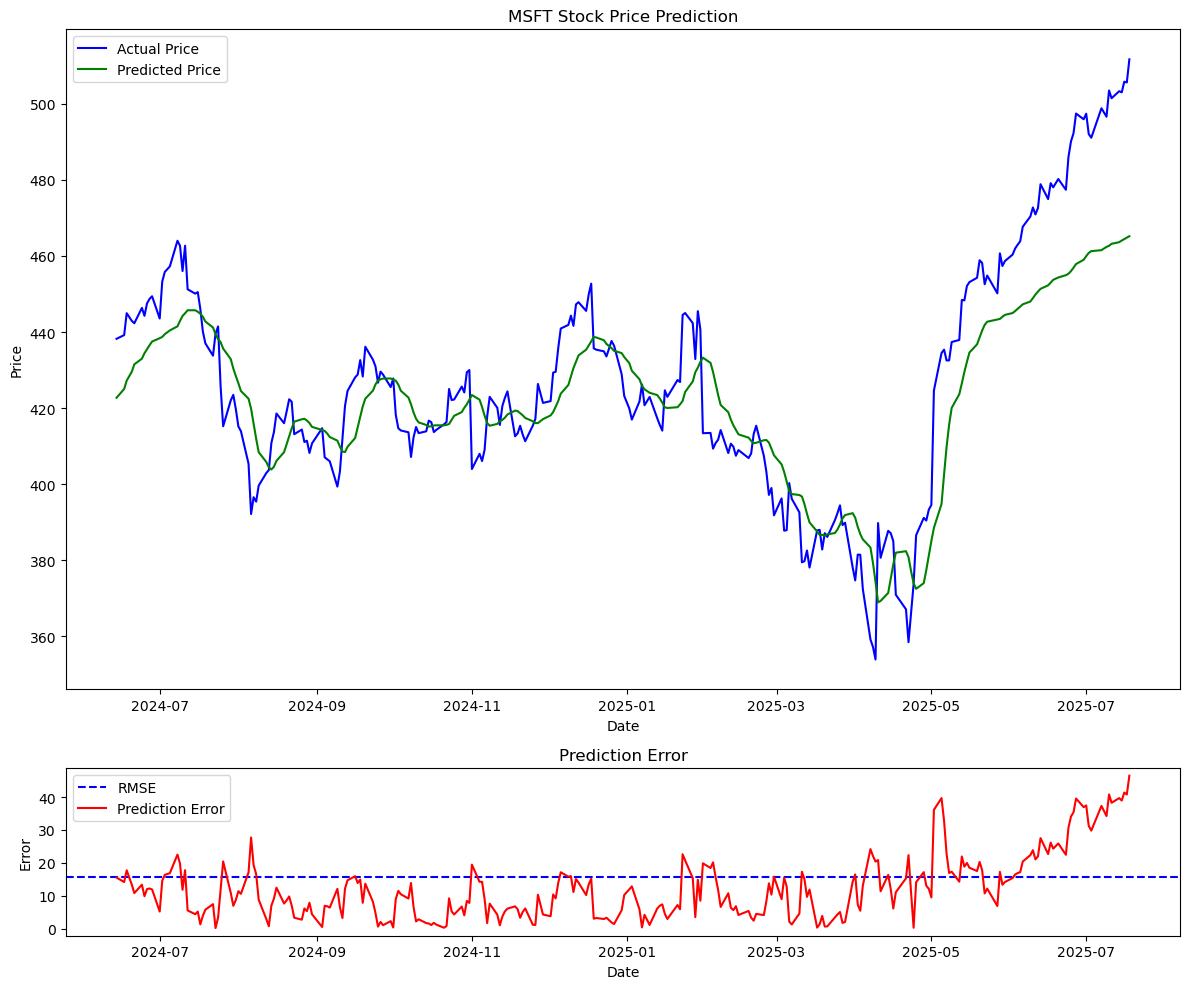

In [202]:
'''
Calculate the RMSE on both the training data, validation and test data sets
RMSE measures the average magnitude of the error between predicted and actual values:
Lower RMSE = better predictions
'''
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:, 0])

print(f"\nFinal Results:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Ensure predictions are numpy arrays
y_test_np = y_test.detach().cpu().numpy().squeeze() if hasattr(y_test, 'detach') else y_test.squeeze()
y_test_pred_np = y_test_pred.detach().cpu().numpy().squeeze() if hasattr(y_test_pred, 'detach') else y_test_pred.squeeze()

# Use numpy dates for x-axis
dates = df.iloc[-len(y_test_np):].index.to_numpy()

# Create figure and gridspec layout
fig = plt.figure(figsize=(12,10))
gs = fig.add_gridspec(4, 1)

# Plot actual vs predicted
ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(dates, y_test_np, color="blue", label='Actual Price')
ax1.plot(dates, y_test_pred_np, color="green", label='Predicted Price')
ax1.legend()
ax1.set_title(f"{ticker} Stock Price Prediction")
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

# Plot error
ax2 = fig.add_subplot(gs[3, 0])
error = abs(y_test_np - y_test_pred_np)
ax2.axhline(test_rmse, color="blue", linestyle="--", label="RMSE")
ax2.plot(dates, error, color='red', label="Prediction Error")
ax2.legend()
ax2.set_title("Prediction Error")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")

plt.tight_layout()
plt.show()

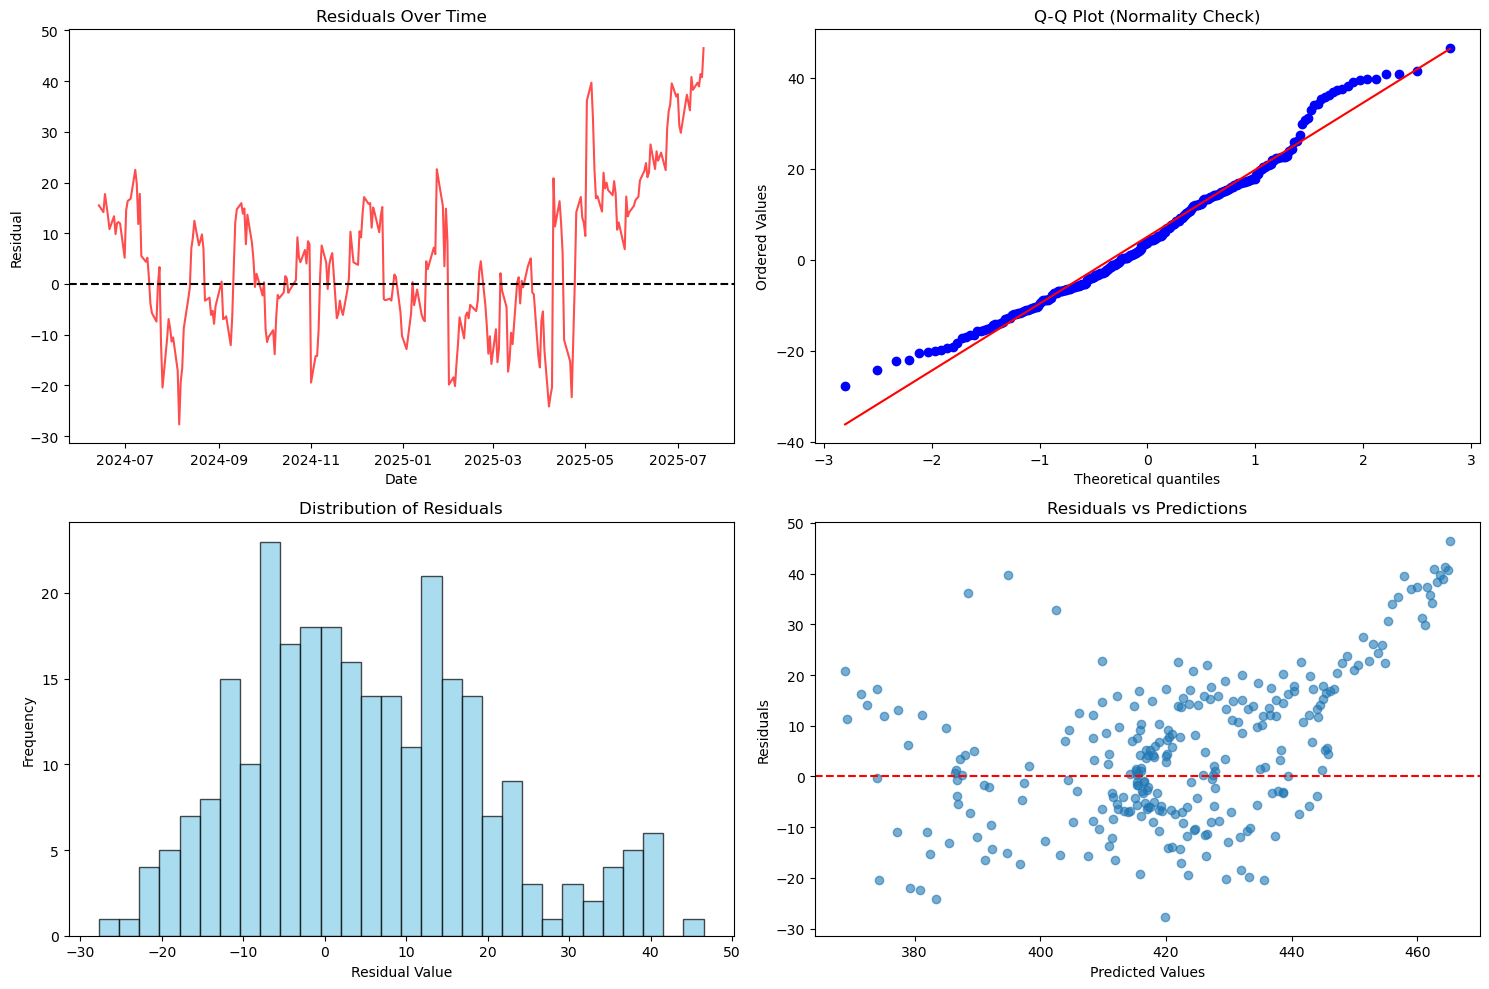

In [203]:
#Residual plots
def plot_residual_analysis(y_test_np, y_test_pred_np, dates):

    #Actual - predicted
    residuals = y_test_np - y_test_pred_np
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    # Residuals over time
    axes[0,0].plot(dates, residuals, color='red', alpha=0.7)
    axes[0,0].axhline(y=0, color='black', linestyle='--')
    axes[0,0].set_title('Residuals Over Time')
    axes[0,0].set_xlabel('Date')
    axes[0,0].set_ylabel('Residual')
    
    # Q-Q plot for normality
    stats.probplot(residuals, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot (Normality Check)')
    
    # Histogram of residuals
    axes[1,0].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].set_title('Distribution of Residuals')
    axes[1,0].set_xlabel('Residual Value')
    axes[1,0].set_ylabel('Frequency')
    
    # Residuals vs Predictions (heteroscedasticity check)
    axes[1,1].scatter(y_test_pred_np, residuals, alpha=0.6)
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    axes[1,1].set_title('Residuals vs Predictions')
    axes[1,1].set_xlabel('Predicted Values')
    axes[1,1].set_ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

plot_residual_analysis(y_test_np, y_test_pred_np, dates)
    
